# **MLF Final Project**
### Vladimír Lukáč

# Import libraries

In [82]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import cv2
import csv
import os
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import RobustScaler, MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam, Adamax, SGD, RMSprop
from keras.datasets import cifar10
from keras import regularizers

from PIL import Image

from scipy.signal import decimate

from google.colab import drive

font = {'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

# Load the dataset

In [83]:
#def sorted_alphanumeric(data):
#    convert = lambda text: int(text) if text.isdigit() else text.lower()
#    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ]
#    return sorted(data, key=alphanum_key)

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Converting .png to .csv

In [ ]:
#def image_to_csv(image_path, output_file):
#    # Open the image file
#    with Image.open(image_path) as img:
#        # Convert image to grayscale (if it's not already)
#        img = img.convert('L')
#        # Convert image data to a numpy array
#        data = np.array(img)
#        # Open the CSV file for writing
#        with open(output_file, 'w', newline='') as csvfile:
#            writer = csv.writer(csvfile)
#            # Write each row of pixel data to the CSV file
#            for row in data:
#                writer.writerow(row)
#
## Usage example
#image_path = '/content/drive/MyDrive/ColabNotebooks/MLFfinal/Train/IMG/img_1.png'
#output_csv_path = 'output.csv'
#image_to_csv(image_path, output_csv_path)

Organizing the 2D data of each *.csv file into 3D matrix, where each "slice" along the x-axis represents one measurement.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


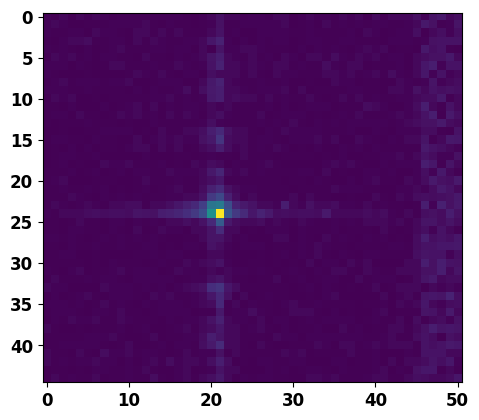

In [ ]:
#drive.mount('/content/drive')

#trainCSVlist = sorted_alphanumeric(os.listdir('/content/drive/MyDrive/ColabNotebooks/MLFfinal/Train/CSV/'))
#testCSVlist = sorted_alphanumeric(os.listdir('/content/drive/MyDrive/ColabNotebooks/MLFfinal/Test/CSV/'))

#trainDF = np.empty((1,45,51))
#testDF = np.empty((1,45,51))

#for trainFile in trainCSVlist:
#            trainDFtemp = np.genfromtxt('/content/drive/MyDrive/ColabNotebooks/MLFfinal/Train/CSV/' + trainFile, delimiter=",", dtype=float)
#            trainDFtemp = trainDFtemp.reshape((1, trainDFtemp.shape[0], trainDFtemp.shape[1]))
#            trainDF = np.concatenate([trainDF,trainDFtemp], axis=0)
#
#for testFile in testCSVlist:
#            testDFtemp = np.genfromtxt('/content/drive/MyDrive/ColabNotebooks/MLFfinal/Test/CSV/' + testFile, delimiter=",", dtype=float)
#            testDFtemp = testDFtemp.reshape((1, testDFtemp.shape[0],testDFtemp.shape[1]))
#            testDF = np.concatenate([testDF,testDFtemp], axis=0)

#example = np.genfromtxt('/content/drive/MyDrive/ColabNotebooks/MLFfinal/Train/CSV/img_3256.csv', delimiter=',')

#plt.imshow(example)

The formed Numpy 3D arrays are saved in a compressed format, so that we don't have to start all over each time we run the code (since it takes 54+min to run it on T4)

In [ ]:
# save to google drive in a compressed format

#np.savez_compressed('/content/drive/MyDrive/ColabNotebooks/MLFfinal/Test/extractedTestcomp.npz',testDF)
#np.savez_compressed('/content/drive/MyDrive/ColabNotebooks/MLFfinal/Train/extractedTraincomp.npz',trainDF)

Load the compressed data from drive and store in raw form for further processing.

In [84]:
x_test_raw = np.load('/content/drive/MyDrive/ColabNotebooks/MLFfinal/Test/extractedTestcomp.npz')
x_train_raw = np.load('/content/drive/MyDrive/ColabNotebooks/MLFfinal/Train/extractedTraincomp.npz')
x_test_raw = x_test_raw['arr_0']
x_train_raw = x_train_raw['arr_0']

y_train_raw = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/MLFfinal/y_train.csv')

In [105]:
print(x_train_raw.shape)
print(y_train_raw.shape)

(16184, 45, 51)
(16182, 2)


## Data Examination

First, look for NaN values

In [85]:
x_train_raw[0,:,:]
NaNs = np.argwhere(np.isnan(x_train_raw))
print(x_train_raw)
print(NaNs)

x_train_NaN = x_train_raw[1:, :, 1:]
randomNaNs = np.argwhere(np.isnan(x_train_NaN))
print(x_train_NaN)
print(randomNaNs)

[[[6.66210203e-310 6.66210203e-310 4.91159153e-310 ... 6.66179359e-310
   6.66210172e-310 0.00000000e+000]
  [6.66195303e-310 5.30498948e-313 5.72938864e-313 ... 6.66195291e-310
   6.66195283e-310 6.66195283e-310]
  [6.66195283e-310 6.66195283e-310 6.66195283e-310 ... 6.66195284e-310
   6.66195284e-310 6.66195284e-310]
  ...
  [6.66195289e-310 6.66195289e-310 6.66195289e-310 ... 6.66195289e-310
   6.66195289e-310 6.66195289e-310]
  [6.66195289e-310 6.66195289e-310 6.66195289e-310 ... 6.66195289e-310
   6.66195289e-310 6.66195289e-310]
  [6.66195289e-310 6.66195289e-310 6.66195289e-310 ... 6.66195292e-310
   6.66195292e-310 6.66195289e-310]]

 [[3.20000000e+001 3.40000000e+001 3.40000000e+001 ... 3.40000000e+001
   3.20000000e+001 3.70000000e+001]
  [3.10000000e+001 3.40000000e+001 3.70000000e+001 ... 3.00000000e+001
   4.50000000e+001 3.40000000e+001]
  [3.20000000e+001 3.10000000e+001 3.20000000e+001 ... 3.80000000e+001
   3.80000000e+001 3.00000000e+001]
  ...
  [3.60000000e+001 3.40

Secondly, identify the labels and their distribution

In [86]:
y_train_raw['target'].value_counts() #class imbalance

target
1    5417
3    4400
2    4307
0    2058
Name: count, dtype: int64

# Data Preprocessing

In [87]:
# removing empty slice and index column, as well as first row, since it contains NaN values, from x_train and test data

x_train = x_train_raw[1:, 1:, 1:]
x_test = x_test_raw[1:, 1:, 1:]

We remove the obsolete id column from the label data, and we shift the values to range from 0 to 2 rather than 1 to 3.

In [91]:
# remove id column from y_train, shift values by 1

y_train = y_train_raw.drop(columns='id')

Checking if all NaN values were removed.

In [92]:
print(np.argwhere(np.isnan(x_train)),np.argwhere(np.isnan(x_test))) #no NaNs left

[] []


Data examination

In [93]:
print(f'Maximum:{x_train.max()}, Minimum: {x_train.min()}, Mean: {x_train.mean()}, Median: {np.median(x_train)}')
print(np.where(x_train == x_train.max()))

Maximum:215.0, Minimum: 30.0, Mean: 37.26359375438872, Median: 34.0
(array([    0,     1,     2, ..., 16180, 16181, 16182]), array([22, 21, 22, ..., 18, 22, 24]), array([19, 17, 19, ..., 17, 19, 20]))


## **Trim and scale**

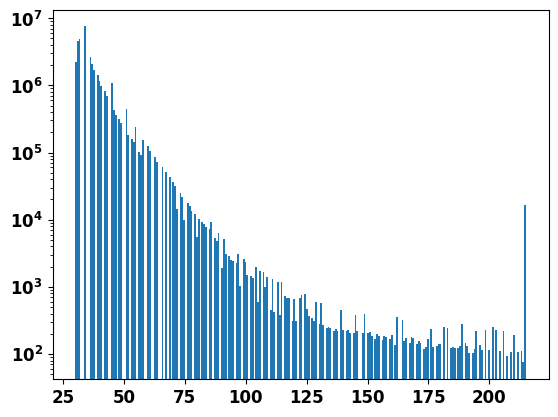

Percentage of values below 125: 99.90771741389673 %


In [94]:
x_train_undim = np.reshape(x_train, (1,35602600))

plt.figure()
plt.yscale('log')
plt.hist(x_train_undim.flatten(), bins=250)

plt.show()

print(f'Percentage of values below 125: {len(np.where(x_train <= 125)[0])/x_train.size*100} %')

Apply scaler, since there are outliers. A Robust scaler has been applied.

In [95]:
#final preprocesing, scaling
scaler = RobustScaler()

#x_trainscaled = x_train.astype('float32') / 255.0

x_trainScaled = np.empty([x_train.shape[0],44*50,1])
for slice in range(x_train.shape[0]):
  x_trainScaled[slice,:,:] = np.reshape(x_train[slice,:,:],[1,44*50,1])
  x_trainScaled[slice,:,:] = scaler.fit_transform(x_trainScaled[slice,:,:])

#x_testscaled = x_test.astype('float32') / 255.0

x_testScaled = np.empty([x_test.shape[0],44*50,1])
for slice in range(x_test.shape[0]):
  x_testScaled[slice,:,:] = np.reshape(x_test[slice,:,:],[1,44*50,1])
  x_testScaled[slice,:,:] = scaler.fit_transform(x_testScaled[slice,:,:])


In [96]:
scaler.center_

array([71.])

In [100]:
print(x_trainScaled.shape)
print(y_trainEncoded.shape)

(16183, 2200, 1)
(14682, 4)


Visulaising scaled data and scaled data statistics

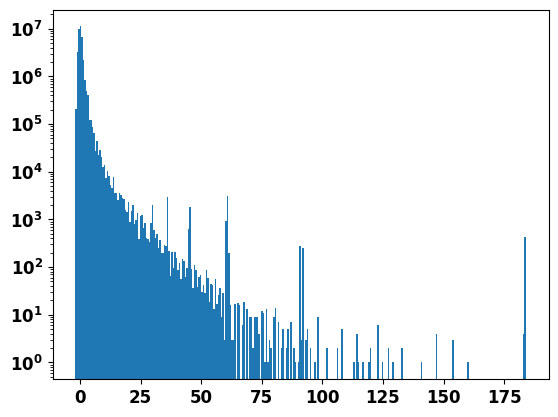

In [97]:
plt.figure()
plt.yscale('log')
plt.hist(x_trainScaled.flatten(), bins=300)

plt.show()

In [98]:
print(f'Maximum:{x_trainScaled.max()}, Minimum: {x_trainScaled.min()}, Mean: {x_trainScaled.mean()}, Median: {np.median(x_trainScaled)}')

Maximum:184.0, Minimum: -2.04, Mean: 0.27361153463548743, Median: 0.0


In [99]:
len(np.where(x_trainScaled <= 120)[0])/x_trainScaled.size*100

99.99869953318016

### **Reduce extra dimensions**

In [ ]:
x_trainScaled = np.squeeze(x_trainScaled)
x_testScaled = np.squeeze(x_testScaled)

y_train = y_train.to_numpy()
y_train = np.squeeze(y_train)

**undersample largest class, one-hot encoding of labels**

In [ ]:
class0ind = np.where(y_train==1)[0]
class0indDec = np.random.choice(class0ind, 1500, replace=False)

x_trainScaled = np.delete(x_trainScaled, class0indDec, axis=0)
y_trainDec = np.delete(y_train, class0indDec, axis=0)

y_trainEncoded = to_categorical(y_trainDec, num_classes = 4)

### **Check data**

In [ ]:
np.unique(y_trainDec, return_counts = True)

(array([0, 1, 2, 3]), array([2058, 3917, 4307, 4400]))

In [ ]:
print("x_trainScaled shape:", x_trainScaled.shape)
print("y_trainEncoded shape:", y_trainEncoded.shape)

x_trainScaled shape: (14683, 2200)
y_trainEncoded shape: (14682, 4)


# Building the model

In [ ]:
model = Sequential()
#model = Sequential()
#model.add(Flatten(input_shape=(2244,)))
#model.add(Dense(2244, activation='gelu'))
#model.add(Dropout(0.2))
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.2))
#model.add(Dense(16, activation='gelu'))
#model.add(Dense(3, activation='softmax'))


#model.add(Flatten(input_shape=(2244,)))
#model.add(Dense(3072, activation='gelu'))
#model.add(Dense(2244, activation='gelu'))
#model.add(Dense(128, activation='gelu'))
#model.add(Dense(3, activation='softmax'))

model.add(Flatten(input_shape=(2200,)))
model.add(Dense(16000, activation='gelu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='gelu'))
model.add(Dense(64, activation='gelu'))
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 2200)              0         
                                                                 
 dense_12 (Dense)            (None, 16000)             35216000  
                                                                 
 dropout_3 (Dropout)         (None, 16000)             0         
                                                                 
 dense_13 (Dense)            (None, 128)               2048128   
                                                                 
 dense_14 (Dense)            (None, 64)                8256      
                                                                 
 dense_15 (Dense)            (None, 4)                 260       
                                                                 
Total params: 37272644 (142.18 MB)
Trainable params: 3

In [ ]:
#optimizer = SGD(learning_rate = 0.01)
#model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

optimizer = Adamax(learning_rate = 0.005, epsilon = 0.2, beta_1=0.9, beta_2=0.999)
#optimizer = SGD(learning_rate = 0.001)
#optimizer = RMSprop(learning_rate = 0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history = model.fit(x_trainScaled, y_trainEncoded, epochs=40, batch_size=32, validation_split = 0.2)

Epoch 1/40
365/368 [============================>.] - ETA: 0s - loss: 1.3624 - accuracy: 0.3512

ValueError: Data cardinality is ambiguous:
  x sizes: 2937
  y sizes: 2936
Make sure all arrays contain the same number of samples.

In [101]:
#plt.figure()
#plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])

In [102]:
#plt.figure()
#plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])

In [103]:
#score = model.evaluate(x_trainScaled, y_trainEncoded, verbose=0)
#print('Training loss:', score[0])
#print(f'Training accuracy: {score[1]*100} %')

# **Outputing data**

In [104]:
predictions = model.predict(x_testScaled)
predictions = pd.DataFrame(predictions)
predictions = predictions.idxmax(axis=1)+1
predictions = pd.DataFrame(predictions, columns=['target'])
predictions.insert(0,'id',np.arange(len(predictions)))

150/150 [==============================] - 0s 2ms/step


In [ ]:
predictions.to_csv('predictions.csv', index=False)